## 필요 함수 import

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from models import *

In [2]:
# 한글 폰트 깨지지 않게 하기
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

## 데이터 불러오기 및 정제

In [3]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/보험료.csv", encoding = 'euc-kr')
raw_data.head()

,고객번호,성별,나이,BMI,자녀수,흡연여부,가입유형,납부유형,보장범위,납입기간,보험료
0,ID100001,남성,19,27.9,0,1,홈쇼핑,은행,19,40,168849
1,ID100002,여성,18,33.8,1,0,인터넷,은행,10,40,17255
2,ID100003,여성,28,33.0,3,0,상담사,카드,12,30,44494
3,ID100004,여성,33,22.7,0,0,홈쇼핑,지로,15,30,219844
4,ID100005,여성,32,28.9,0,0,인터넷,카드,9,30,38668


In [4]:
# 이전 다중선형 회귀분석에서 사용한 데이터 사용 - get_dummy만 다름(drop_first = False)
raw_data.dropna(inplace = True)
raw_data.drop(['고객번호'], axis = 1, inplace = True)
df = pd.get_dummies(raw_data)
df.head()

,나이,BMI,자녀수,흡연여부,보장범위,납입기간,보험료,성별_남성,성별_여성,가입유형_상담사,가입유형_인터넷,가입유형_홈쇼핑,납부유형_은행,납부유형_지로,납부유형_카드
0,19,27.9,0,1,19,40,168849,1,0,0,0,1,1,0,0
1,18,33.8,1,0,10,40,17255,0,1,0,1,0,1,0,0
2,28,33.0,3,0,12,30,44494,0,1,1,0,0,0,0,1
3,33,22.7,0,0,15,30,219844,0,1,0,0,1,0,1,0
4,32,28.9,0,0,9,30,38668,0,1,0,1,0,0,0,1


In [5]:
df_x = df.drop(['보험료'], axis = 1, inplace=False)
df_y = df['보험료']

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=777)

print("df_train_x:",df_train_x.shape)
print("df_test_x:",df_test_x.shape)
print("df_train_y:",df_train_y.shape)
print("df_test_y:",df_test_y.shape)

df_train_x: (936, 14)
df_test_x: (402, 14)
df_train_y: (936,)
df_test_y: (402,)


## Random Forest 모델

In [6]:
'''
디폴트 값으로 정의된 모델을 기반으로 학습했을때,
학습 데이터나 테스트 데이터셋에 대해 성능차이가 거의 없으며, 잘 학습된 모습을 보인다.

파라미터의 조정 이후에도 성능을 계속 유지하거나 더 좋은 성능을 보이는지 확인해보도록 하겠다. 


'''
model_name = 'rf'

rf_uncustomized = RandomForestRegressor(random_state = 777)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.996
Score on test set: 0.959


In [7]:
rf_uncustomized.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 777,
 'verbose': 0,
 'warm_start': False}

In [8]:
# default 파라미터 세팅

hyperparameters = {
    'min_samples_leaf' : [1],
    'min_samples_split' : [2],
    'max_depth' : [None],
    'n_estimators' : [100]
}         

#### 1. n_estimators 조정

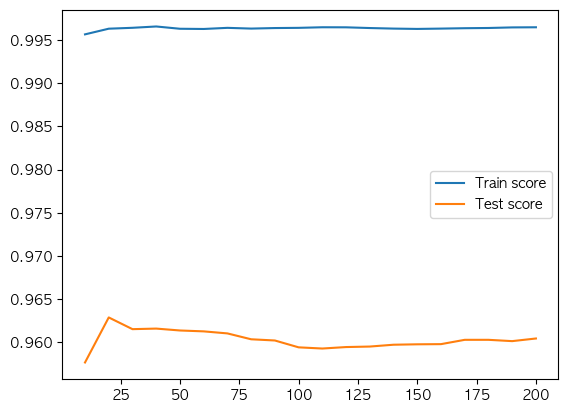

In [9]:
hyperparameters['n_estimators'] = [x * 10 for x in range(1,21)]
df_score = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'n_estimators', 1)

In [10]:
df_score.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.996,0.958
1,20,0.996,0.963
2,30,0.996,0.962
3,40,0.997,0.962
4,50,0.996,0.961
5,60,0.996,0.961
6,70,0.996,0.961
7,80,0.996,0.960
8,90,0.996,0.960
9,100,0.996,0.959


In [11]:
hyperparameters['n_estimators'] = [20]

1. n_estimators가 20일때 테스트 성능이 잠깐 상승했다가
   이후로는 하락세와 상승세가 불규칙하게 나타나는 것을 볼 수 있음
2. 따라서 n_estimators는 20을 선택함

#### 2. min_samples_leaf 조정

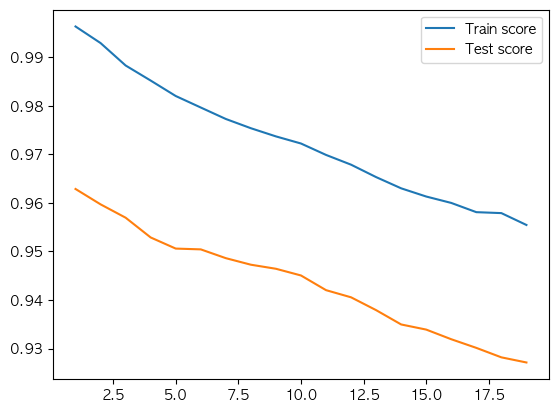

In [12]:
hyperparameters['min_samples_leaf'] = [x for x in range(1,20)]
df_score = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_leaf', 1)

In [13]:
df_score.round(3)

,min_samples_leaf,TrainScore,TestScore
0,1,0.996,0.963
1,2,0.993,0.960
2,3,0.988,0.957
3,4,0.985,0.953
4,5,0.982,0.951
5,6,0.980,0.950
6,7,0.977,0.949
7,8,0.975,0.947
8,9,0.974,0.946
9,10,0.972,0.945


In [14]:
hyperparameters['min_samples_leaf'] = [1]

1. min_samples_leaf의 갯수가 늘어날수록 학습, 테스트 데이터셋에 대한 모델의 성능이 줄어드는 것을 확인할 수 있다.
2. 이에 따라 min_samples_leaf를 1로 선택하지만,
   리프의 숫자가 적을수록 효율적임을 알고 있기 때문에 max_depth 이후로 한번 더 성능을 조정해보기로 결정하였다.

#### 3. min_samples_split 조정

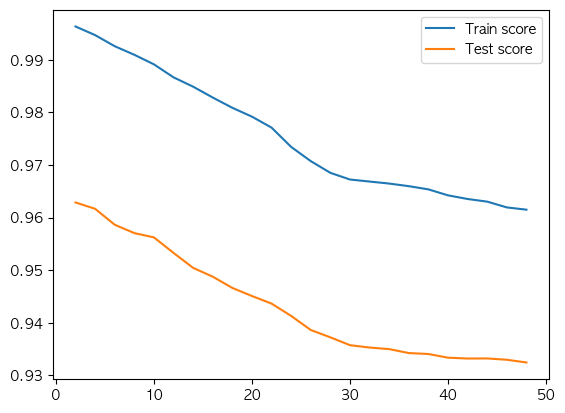

In [15]:
hyperparameters['min_samples_split'] = [x*2 for x in range(1,25)]
df_score_split = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_split',1)

In [16]:
df_score_split.round(3)

,min_samples_split,TrainScore,TestScore
0,2,0.996,0.963
1,4,0.995,0.962
2,6,0.993,0.959
3,8,0.991,0.957
4,10,0.989,0.956
5,12,0.987,0.953
6,14,0.985,0.950
7,16,0.983,0.949
8,18,0.981,0.947
9,20,0.979,0.945


In [17]:
hyperparameters['min_samples_split'] = [2]

1. min_samples_split의 갯수가 늘어날수록 학습, 테스트 데이터셋에 대한 모델의 성능이 줄어드는 것을 확인할 수 있다.
2. 따라서 min_samples_leaf와 같이 max_depth 이후로 한번 더 조정해보기로 결정하였다. 

#### 4. max_depth 조정

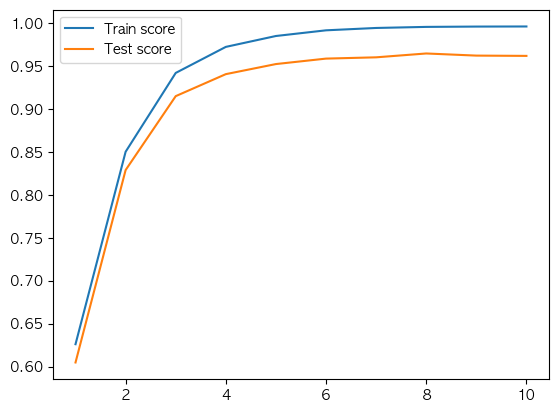

In [18]:
hyperparameters['max_depth'] = [x for x in range(1,11)]
df_score_depth = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'max_depth', 1)

In [19]:
df_score_depth.round(3)

,max_depth,TrainScore,TestScore
0,1,0.626,0.605
1,2,0.850,0.829
2,3,0.942,0.915
3,4,0.972,0.940
4,5,0.985,0.952
5,6,0.992,0.959
6,7,0.994,0.960
7,8,0.996,0.965
8,9,0.996,0.962
9,10,0.996,0.962


In [20]:
hyperparameters['max_depth'] = [9]

1. max_depth가 클수록 트리의 깊이가 깊어지면서 학습 및 테스트 데이터셋의 성능도 함께 상승하는 폭을 보이다가    
max_depth의 값이 9가 된 이후로는 특정 값에 수렴하여 계속해서 이어지는것을 볼 수 있다.     
이는 이 이상 깊이가 깊어져도 더이상 학습의 성능을 개선시키지 못한다고 판단된다.
2. 따라서 max_depth가 변해도 더이상 성능이 변하지 않는 값인 9로 max_depth의 갑을 선택했다. 

#### 5. min_samples_leaf, min_samples_split 다시 조정

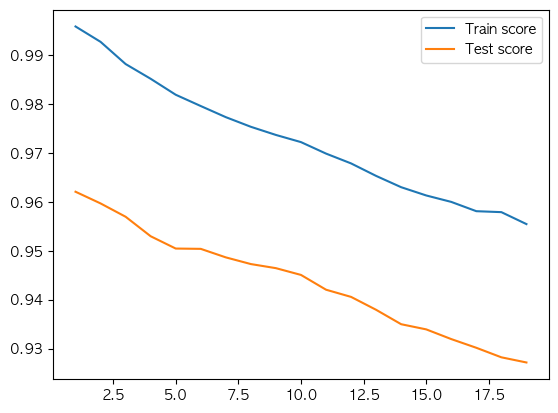

In [21]:
hyperparameters['min_samples_leaf'] = [x for x in range(1,20)]
df_score = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_leaf', 1)

In [22]:
hyperparameters['min_samples_leaf'] = [1]

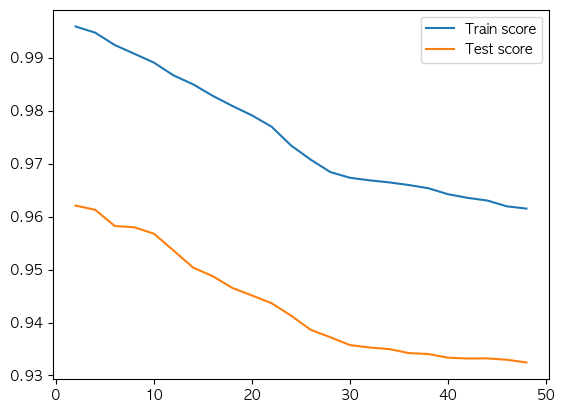

In [23]:
hyperparameters['min_samples_split'] = [x*2 for x in range(1,25)]
df_score_split = run_models(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_split',1)

In [24]:
hyperparameters['min_samples_split'] = [2]

- 재조정 했음에도 불구하고, 다른 변화는 없으므로 leaf와 split을 각각 1과 2로 선택하였다. 

### 4. 최종모델 선정

In [25]:
v_feature_name = df_train_x.columns
rf_final = RandomForestRegressor(n_estimators=hyperparameters['n_estimators'][0],
                                 min_samples_leaf = hyperparameters['min_samples_leaf'][0], 
                                 min_samples_split = hyperparameters['min_samples_split'][0],
                                 max_depth = hyperparameters['max_depth'][0],
                                 random_state=777 )

rf_final.fit(df_train_x, df_train_y)
rf_final.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 9,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 777,
 'verbose': 0,
 'warm_start': False}

In [26]:
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.996
Score on test set: 0.962


In [27]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
3,흡연여부,0.624
1,BMI,0.149
0,나이,0.113
4,보장범위,0.092
5,납입기간,0.012
2,자녀수,0.007
7,성별_여성,0.001
12,납부유형_지로,0.000
6,성별_남성,0.000
8,가입유형_상담사,0.000


Text(0, 0.5, '변수')

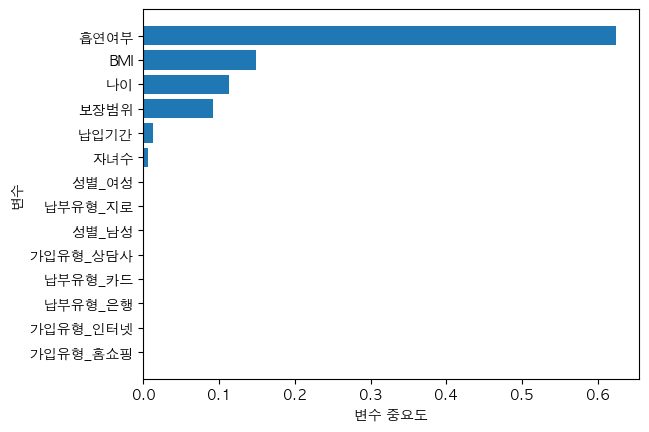

In [28]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

#### 결론
파라미터를 조정한 모델의 결과로 학습 데이터셋에 0.996, 테스트 데이터셋에 0.962로    
처음에 조정하지 않은 모델과 비교하였을 때, 테스트 데이터에 대한 성능이 상승함을 알 수 있다. 
약간의 차이이지만, 하이퍼파라미터 튜닝을 통해 모델의 성능을 약간 더 끌어올렸다.


* 다른 모델과의 비교
   - 같은 데이터로 학습한 Ridge, Lasso, Elastic 회귀분석 모델에 비해 더 높고 안정적인 성능을 보임
   - 변수 중요도는 위 비교군이 되는 모델과 비슷한 순위로 나타났으며, 여기서도 흡연여부가 높은 연관성이 있음을 확인할 수 있음
    - Decision Tree와 비교하였을 때는 비슷한 성능을 보인다.